# CSC424 - Machine Learning - Assignment 1

<br>

### Team - Random Access Memories
> #### Rivu Bhattacharjee — 1910626
> #### Ahnaf Abdullah — 2130223
> #### Tausia Tahsin Nuzum — 2221415



## Problems

#### Assignment 1A

1.	Get introduced to the MNIST Fashion Dataset
2.	Download, unzip and then load the Fashion MNIST dataset into your memory. You can directly load the Fashion dataset using the code provided here.
3.	You must read training and test images and labels in the numpy arrays.
4.	Draw a plot that have 10 images with label names from 10 different classes
5.	Preprocess the train and test images.
6.	Train the K-Nearest Neighborhood Classifier for $k = 1,3,5,7$ separately.
7.	Predict the test images with your K-nearest neighborhood classifier.

    * Calculate the confusion matrix, accuracy, and F1 score for a given k
    * You must experiment with the kNN classifier for $k = 1, 3, 5, 7$ and show confusion matrices and the performances for each k.

8.	Plot a graph (k vs macro F1 avg) with k in x-axis and macro F1 average in y-axis

#### Assignment 1B

1. Download, unzip and then load the Fashion MNIST dataset into your memory. You can directly load the Fashion dataset using the code provided here.
2. You must read training and test images and labels in the numpy arrays.
3. Preprocess the train and test images.
4. Split the train images and the train labels into 80% train set and 20% validation set randomly.

    * Train the linear classifier with softmax (as designed in class) and cross entropy loss with your train set with a batch size and a learning rate provided below. For each training, we plot the training loss (blue) and validation loss (red) against the 100 epochs each time. So you will have total six plots for six experiments.

        * Batch size 2048, 1024, 512

        * Learning rate: 0.001, 0.0001

5. Finally, take the Batch size and the Learning rate that have provided you the best macro F1 score, train the linear  classifier with the train set  using that batch size and learning rate for 100 epochs and then run the test data on  the trained classifier (learned W and b), show the confusion matrix and Performance of the test data

6. For the training done in action 5, plot the images of the learned weights for each class.



## Setup



### Imports and Defines

In [ ]:
import os         # file en
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp

import tqdm
import yaml
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split

from urllib import request  # HTTP downloading, download_and_load_dataset
import gzip     # extract tarballs

from google.colab import files   # download file programatically when done
import pickle
#from dataclasses import dataclass, field

### Helper Functions



In [ ]:
def download_and_load_dataset(write_to_file=False, BASE_URL="http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"):
    """Downloads the dataset pointed to by BASE_URL (should point to a MNIST-like dataset
    following all naming conventions) and returns 4 sets of training images, training labels, testing images and testing labels"""

    filename = [
        ["training_images","train-images-idx3-ubyte.gz"],
        ["test_images","t10k-images-idx3-ubyte.gz"],
        ["training_labels","train-labels-idx1-ubyte.gz"],
        ["test_labels","t10k-labels-idx1-ubyte.gz"]
        ]

    if write_to_file:
        import pickle

    def download_mnist():
        for name in filename:
            if not os.path.isfile(name[1]):
                print("Downloading "+name[1]+"...")
                request.urlretrieve(BASE_URL+name[1], name[1])
            else:
                print("File " + name[1] + " already downloaded")
        print("Download complete.")

    def save_mnist():
        mnist = {}
        for name in filename[:2]:
            with gzip.open(name[1], 'rb') as f:
                mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
        for name in filename[-2:]:
            with gzip.open(name[1], 'rb') as f:
                mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
        if write_to_file:
            with open("mnist.pkl", 'wb') as f:
                pickle.dump(mnist,f)
            print("Save complete.")
        return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]


    download_mnist()
    return save_mnist()


In [ ]:
def show_image(img_arr: np.array, shape=(28, 28), label=None, boxborder=True):
    """A highly customizable plotter function that renders a single greyscale image. """
    plt.figure(figsize=(2, 2))
    #
    if boxborder:
      plt.gca().set_xticks([])
      plt.gca().set_yticks([])
      plt.gca().spines[:].set_visible(True)
    else:
      plt.axis('off')

    plt.imshow(img_arr.reshape(shape), cmap="Greys")
    if label is not None:
        plt.title(label)
    plt.show()

In [ ]:
def LABEL_MAP(index: int) -> str:
  """Maps every index number representing a class in the Fashion MNIST dataset to the name of the class(i.e string)"""
  label_map: dict = {
      0: "T-shirt/top",
      1: "Trouser",
      2: "Pullover",
      3: "Dress",
      4: "Coat",
      5: "Sandal",
      6: "Shirt",
      7: "Sneaker",
      8: "Bag",
      9: "Ankle boot"
  }

  try:
    return label_map[index]
  except KeyError:
    raise KeyError("{} does not represent a valid class!".format(index)) from None

print(LABEL_MAP(4))

Coat


In [ ]:
def normalize(arr: np.array):
    """Returns a new array derived from the values of <code>arr</code> such that every value in <code>arr</code> falls in the interval [0, 1]"""
    max_val = np.max(arr)
    min_val = np.min(arr)

    return (arr - min_val) / (max_val - min_val)

def standardize(arr: np.array):
    """Returns a new array derived from the values of <code>arr</code> such that all the values in the array have a mean of 0 and a standard deviation of 1"""
    mean = np.mean(arr)
    sd = np.std(arr)

    return (arr - mean) / sd

In [ ]:
def accuracy(true_labels, predicted_labels):
    """Function to compute accuracy"""
    # condition(vec1, vec2) returns a boolean array V where V_i = True if condition(vec1_i, vec2_i) is True
    # then we take the average of all the values in the resultant array (True is 1, False is 0)
    # hence, we get a percentage that describes how many of the labels were correct
    return np.mean(true_labels == predicted_labels)

# Abdullah: why do we have this? We're using sklearn's f1score anyway...
# Function to compute F1 score (macro-averaged)
def f1_score_macro(true_labels, predicted_labels, num_classes=10):
    matrix = confusion_matrix(true_labels, predicted_labels, num_classes)
    precision = np.diag(matrix) / np.sum(matrix, axis=0)
    recall = np.diag(matrix) / np.sum(matrix, axis=1)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    return np.nanmean(f1_scores)  # NaN handling if division by zero

In [ ]:
def show_ConfusionMatrix(predicted_labels: np.array, title: str):
    """Renders a confusion matrix based on the test labels loaded by the
    dataloader, and predicted labels resulting from the output of some classifier. """
    class_names = [LABEL_MAP(i) for i in range(10)]
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, predicted_labels), display_labels=class_names)
    disp = disp.plot(xticks_rotation=45)
    plt.title('Confusion Matrix: {}'.format(title))
    plt.show()

In [ ]:
def numpyarr_to_cupyarr(arr) -> cp.array:
    return cp.array(arr)

def cupyarr_to_numpyarr(arr) -> np.array:
    return arr.get() if hasattr(arr, 'get') else arr

## Assignment 1A



---



---

*WARNING: Do not click Run on section headers! Run individually*

*WARNING: Run this entire section on a Colab TPU instance*

### Part 1-3

> 1. *Get introduced to the MNIST Fashion Dataset*
>
> 2. *Download, unzip and then load the Fashion MNIST dataset into your memory. You can directly load the Fashion dataset using the code provided here.*
>
> 3. *You must read training and test images and labels in the numpy arrays.*



The Fashion-MNIST dataset is a modern alternative to the classic MNIST dataset, designed for machine learning and computer vision tasks. Fashion-MNIST consists of 70,000 grayscale images of fashion items, divided into 60,000 training images and 10,000 test images. Each image is a 28x28 pixel grayscale representation of a single fashion item.

The dataset includes 10 categories of clothing and accessories, and each image is labeled with one of these 10 classes:

1. T-shirts/tops
2. Trousers
3. Pullovers
4. Dresses
5. Coats
6. Sandals
7. Shirts
8. Sneakers
9. Bags
10. Ankle boots

The dataset is designed to be a drop-in replacement for the original MNIST dataset, maintaining the same image size and structure, but providing a more challenging and relevant dataset for modern machine learning tasks.
This dataset is widely used for benchmarking machine learning algorithms, particularly in image classification tasks, and serves as a stepping stone between simple digit recognition and more complex computer vision challenges.

We begin by loading the Fashion MNIST dataset by calling the helper function `download_and_load_dataset()`, which returns the loaded training and testing image datasets. This helper function reads in the training and testing images from the tarballs into numpy arrays for us, which is very convenient

In [ ]:
# Load training and test datasets
train_images, train_labels, test_images, test_labels = download_and_load_dataset()

Download complete.


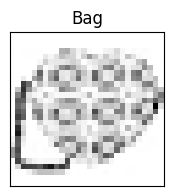

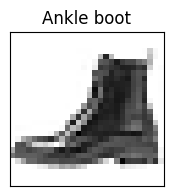

In [ ]:
random_index = np.random.randint(0, len(train_images))
show_image(train_images[random_index], label=LABEL_MAP(train_labels[random_index]))

random_index = np.random.randint(0, len(test_images))
show_image(test_images[random_index], label=LABEL_MAP(test_labels[random_index]))

### Part 4

> 4. Draw a plot that have 10 images with label names from 10 different classes

Here we present as an example an image from all the classes in the Fashion MNIST dataset.

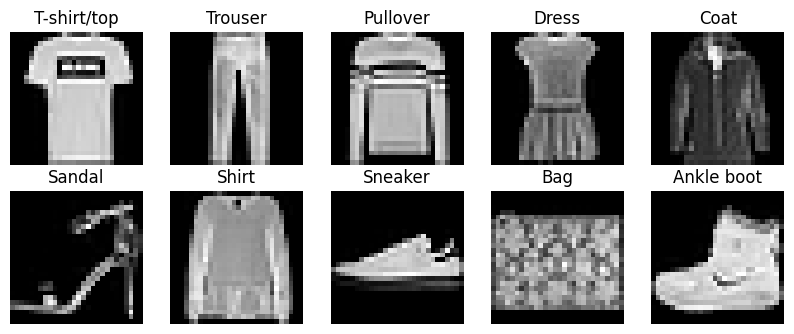

In [ ]:
"""
  Plot 10 images from different classes
  @author Tausia
"""
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    class_idx = np.where(train_labels == i)[0][0]  # Find the first occurrence of each class
    #print(np.where(train_labels == i)[0])
    plt.imshow(train_images[class_idx].reshape(28, 28), cmap='gray')
    plt.title(LABEL_MAP(i))
    plt.axis('off')
plt.show()



### Part 5

> 5. Preprocess the train and test images.


Preprocessing involves typically applying a transform over all the input data uniformly to achieve better performance or to better reflect or diminish the importance of different features of the data.

The [notebook](https://colab.research.google.com/drive/1mIAwYHkVa-XseX9kJ9jlt06kxCR3KABe?usp=sharing&authuser=0#scrollTo=kx8xDuAzJvAR) that was shared with us states

> Normalization is a process that changes the range of pixel intensity values to a standard range, it helps the model to converge faster. To normalize the images, we will use the following steps:
>
> Normalize to [0-1] by dividing each pixel by 255.
Subtract the ImageNet mean (0.485, 0.456, 0.406) and divide by the ImageNet standard deviation (0.229, 0.224, 0.225).
After normalization, we need to flatten the images. Use `np.reshape` to flatten the images.

Subtracting the values of each data point by the mean and dividing it by standard deviation is referred to as **standardization**, or **z-score normalization**, which ensures the datapoints have a mean of 0 and an SD of 1. This is actually not the same as **min-max normalization**, whose goal is to ensure all features are weighted equally.

This seems to imply that we need to apply both normalization and standardization to the dataset. However, I will demonstrate that any set of values can only be standardized or normalized, but not both.

---
Let $x \in \mathbb{R}^n$.
* $x$ is normalized if and only if $x_i \in [0, 1]$ $∀x_i \in x$.
* $x$ is standardized if and only if $μ = \frac{∑x_i}{n} = 0$ and $σ=\sqrt{\frac{∑(x_i - μ)^2}{n}}=1$

But if $x$ is normalized, then $∀x_i(x_i \geq 0)$ and $μ$ will be $> 0$, if $x_i$ is nonzero.<br>If $x =\mathbf{0} ⃗$ , then $μ = 0$, but $σ \neq 1$, so $x$ is not standardized

And similar logic can be used to show that for $x$ that is standardized $∃x_i(x_i < 0) \therefore x_i ∉ [0, 1]$, so $x$ is not normalized.

---
This should be enough, but I also have written a code sample to demonstrate how the dataset we are working can either be standardized or normalized but not both.

In [ ]:
norm_train_images = normalize(train_images) # Normalize pixel values to range [0, 1]
stan_train_images = standardize(train_images)   # Standardize pixel values to have mean 0 and SD 1

norm_test_images = normalize(test_images)
stan_test_images = standardize(test_images)

print("Training images")
for arr in (norm_train_images, stan_train_images, train_images):
  print("Max: ", np.max(arr))
  print("Min: ", np.min(arr))
  print("Mean is: ", np.mean(arr), "SD is: ", np.std(arr))
  print()


Training images
Max:  1.0
Min:  0.0
Mean is:  0.2860405969887955 SD is:  0.35302424451492237

Max:  2.0224089821146136
Min:  -0.8102576563313192
Mean is:  -1.74808013869143e-17 SD is:  1.0

Max:  255
Min:  0
Mean is:  72.94035223214286 SD is:  90.02118235130519




Standardization only makes sense for data that is normally distributed, and while that is true for many naturally occuring processes, I feel like it would make more sense for us to apply normalization in this case.

---

But personally, I doubt that normalization will have any benefits, because
* All the pixels in our images have equal weight, and range from 0 to 255.
* Floating point operations are significantly slower than integer operations

Regardless, we will use the normalized array as our preprocessed data and use it for the next parts of the question.

*I hypothesize that: even without preprocessing we should arrive at the same results, and we would have a measurably better performance on the non-preprocessed data as it involves only integers.*

### Part 6-7

> Train the K-Nearest Neighborhood Classifier for  $k=1,3,5,7$  separately.
>
> Predict the test images with your K-nearest neighborhood classifier.

K-Nearest Neighbors (KNN) is a simple algorithm used for classification, including tasks like image classification in the Fashion MNIST dataset. Fashion MNIST contains 70,000 grayscale images of 28x28 pixels, representing 10 different types of clothing (e.g., shirts, shoes, trousers). Each image is treated as a 784-dimensional vector, where each pixel is a feature. KNN classifies images based on how similar they are to images from the training set, using Euclidean distance.

For KNN, there is no seperate training phase, as prediction uses the training data to determine and classify the image.

---

We will be using the euclidean distance as our metric for KNN. The euclidean distance between 2 vectors $p, q \in \mathbf{R}^n$ is defined as

$$
L_2 = \sqrt{∑(q_i - p_i)^2}
$$

The strategy for KNN is simple:

1. Find the distance metric between the image vector and all other images vectors in the training data
2. Sort the distances by least  

TODO: write KNN explanation, explain what predict(single-threaded) does.


In [ ]:
# Function to calculate Euclidean distance between two points
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))


In [ ]:
def k_nearest_neighbor(
    new_image: np.array,
    train_images: np.array,
    train_labels: np.array,
    k: int
) -> int:
    """Implementation of the K nearest neighbor(KNN) algorithm. """

    if (k <= 0) or (k % 2 == 0):
        raise Exception("KNN is undecidable for even k and invalid for k <= 0")

    # tldr: find the set of distances between this image and all other images, and return the k images for which the distance were smallest
    distances = euclidean_distance(new_image, train_images)         # find distance between the new image, and every other image in train_images
    indices = np.argsort(distances)                                 # sort the distance array based on indices(~no performance penalty), so we can retrieve the k smallest distances and the images that correspond to them

    # tldr: this selects the class that appeared the most out of the k images
    nearest_neighbors = train_labels[indices[:k]]                         # obtain the class those k images belonged to.
    values, counts = np.unique(nearest_neighbors, return_counts=True)     # collate multiple classes in the nearest_neighbors list into a smaller list (where counts keeps track of the number of times each value appeared)
    predicted_label = values[np.argmax(counts)]                           # select the class for greatest value of count, and the value

    return predicted_label


In [ ]:
def predict(test_images, train_images, train_labels, k):
    """Applies the KNN algorithm to each image in test_images to determine the class of the test_images, returning it as a result.

    Single-threaded. This is likely to be slow.
    """
    predictions = np.array([])

    for i, image in enumerate(tqdm.tqdm(test_images, ncols=100, desc="Predicting")):
        predicted_label = k_nearest_neighbor(image, train_images, train_labels, k)
        predictions = np.append(predictions, predicted_label)
    return predictions

#### **Trial Run**

Before we invoke parallelization, we want to ensure we are using the most efficient and best parameters for training. We run a small test to see how a small sample of the data is faring and continue from there.

It turns out that, indeed working with integers allow for much faster operations, but with an error penalty. Otherwise, there is virtually no difference in error between normalized and standardized data. We will go ahead and proceed with normalized data as it is producing the least error.

*Findings: Working with integers is significantly faster, but comes with a small accuracy penalty.*

In [ ]:
# time test using normalized
print("Normalized")
predicted_labels1 = predict(norm_test_images[:500], norm_train_images, train_labels, 3)

# time test using standardized
print("Standardized")
predicted_labels2 = predict(stan_test_images[:500], stan_train_images, train_labels, 3)

# time test without preprocessing
print("No preprocessing")
predicted_labels3 = predict(test_images[:500], train_images, train_labels, 3)

print()
print("accuracy normalized:", accuracy(test_labels[:500], predicted_labels1))
print("accuracy standardized:", accuracy(test_labels[:500], predicted_labels2))
print("accuracy no preprocessing:", accuracy(test_labels[:500], predicted_labels3))
# print("f1 score:", f1_score_macro(test_labels, predicted_labels))

Normalized


Predicting: 100%|█████████████████████████████████████████████████| 500/500 [02:11<00:00,  3.80it/s]


Standardized


Predicting: 100%|█████████████████████████████████████████████████| 500/500 [01:59<00:00,  4.19it/s]


No preprocessing


Predicting: 100%|█████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.96it/s]


accuracy normalized: 0.87
accuracy standardized: 0.866
accuracy no preprocessing: 0.75


#### **Parallelization**

Without parallelization, it takes 10 minutes on "No Preprocessing" and 48 minutes on "Normalized" sets to train. This equates to roughly 4 hours of training for just KNN. It is time for us to employ whatever resources we have at hand to ensure we can finish this task much faster.

We employ our knowledge of Operating Systems concepts and design a function that leverages modern day architecture that emphasizes multicore performance, in order to process multiple images at once. The performance difference can be shocking.

In [ ]:
def predict_MT(test_images, train_images, train_labels, k, max_workers=os.cpu_count()):
    """Applies the KNN algorithm to each image in test_images to determine the class of the test_images, returning it as a result.

    Significant optimizations are being made in this function to parallelize the problem. For fastest results, ensure you run this on a machine with
    a lot of cores.
    """
    from tqdm.contrib.concurrent import thread_map  # or thread_map
    import time

    def worker(image):
        nonlocal k
        nonlocal train_images
        nonlocal train_labels
        return k_nearest_neighbor(image, train_images, train_labels, k)

    r = thread_map(worker, test_images, max_workers=max_workers)
    return np.array(r)

###### Standard Colab instance

```python
print("This is being run on a standard Colab instance!")
!cat /proc/cpuinfo
print("Cores: ", os.cpu_count())
predicted_labels = predict_MT(norm_test_images[:500], norm_train_images, train_labels, 3)
print("accuracy normalized multithread:", accuracy(test_labels[:500], predicted_labels))
```



```
This is being run on a standard Colab instance!
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 1
initial apicid	: 1
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

Cores:  2
100%  500/500 [01:40<00:00,  6.03it/s]
accuracy normalized multithread: 0.87
```



###### Colab TPU

```python
print("This is being run on a Colab TPU instance!")
#!cat /proc/cpuinfo   # 96 cores too much info xd
print("Cores: ", os.cpu_count())
predicted_labels = predict_MT(norm_test_images[:500], norm_train_images, train_labels, 3)
print("accuracy normalized multithread:", accuracy(test_labels[:500], predicted_labels))
```

```
This is being run on a Colab TPU instance!
Cores:  96
100%  500/500 [00:06<00:00, 198.39it/s]
accuracy normalized multithread: 0.87
```



#### Prediction
After setup, we change instances to Colab TPU and begin executing these workloads. We save the results to disk so we can reuse them for the confusion matrices later on an ordinary instance.

In [ ]:
# K = 1
k1_predicted_labels = predict_MT(norm_test_images, norm_train_images, train_labels, 1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# K = 3
k3_predicted_labels = predict_MT(norm_test_images, norm_train_images, train_labels, 3, max_workers=os.cpu_count()*2)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# K = 5
k5_predicted_labels = predict_MT(norm_test_images, norm_train_images, train_labels, 5, max_workers=os.cpu_count()*1.5)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# K = 7
k7_predicted_labels = predict_MT(norm_test_images, norm_train_images, train_labels, 7, max_workers=os.cpu_count()*2)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# TPU instances dont last very long, i dont wanna lose these computations
np.save("k1_predicted_labels", k1_predicted_labels)
np.save("k3_predicted_labels", k3_predicted_labels)
np.save("k5_predicted_labels", k5_predicted_labels)
np.save("k7_predicted_labels", k7_predicted_labels)
print(k7_predicted_labels)

[9 2 1 ... 8 1 7]


In [ ]:
# we saved our results in .npy files, upload them and then run this
k1_predicted_labels = np.load("k1_predicted_labels.npy")
k3_predicted_labels = np.load("k3_predicted_labels.npy")
k5_predicted_labels = np.load("k5_predicted_labels.npy")
k7_predicted_labels = np.load("k7_predicted_labels.npy")
print(k7_predicted_labels)

[9 2 1 ... 8 1 7]


---


##### Results for KNN $k=1$

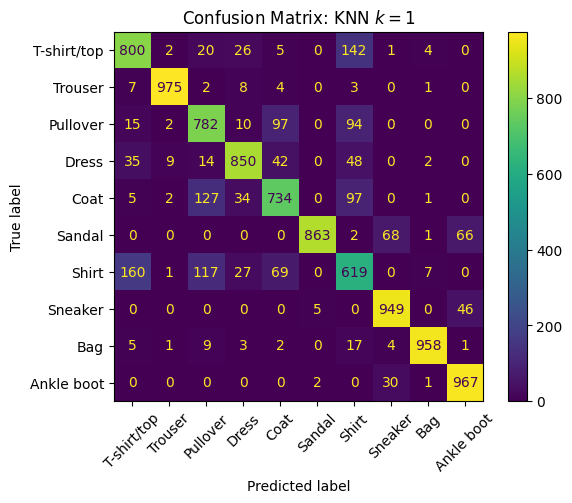


	KNN k=1

              precision    recall  f1-score   support

 T-shirt/top     0.7790    0.8000    0.7893      1000
     Trouser     0.9829    0.9750    0.9789      1000
    Pullover     0.7302    0.7820    0.7552      1000
       Dress     0.8873    0.8500    0.8682      1000
        Coat     0.7702    0.7340    0.7517      1000
      Sandal     0.9920    0.8630    0.9230      1000
       Shirt     0.6057    0.6190    0.6123      1000
     Sneaker     0.9021    0.9490    0.9250      1000
         Bag     0.9826    0.9580    0.9701      1000
  Ankle boot     0.8954    0.9670    0.9298      1000

    accuracy                         0.8497     10000
   macro avg     0.8527    0.8497    0.8503     10000
weighted avg     0.8527    0.8497    0.8503     10000



In [ ]:
show_ConfusionMatrix(k1_predicted_labels, "KNN $k=1$")
print('\n\tKNN k=1\n')
print(classification_report(test_labels, k1_predicted_labels, target_names=[LABEL_MAP(i) for i in range(10)], digits=4))

##### Results for KNN $k=3$

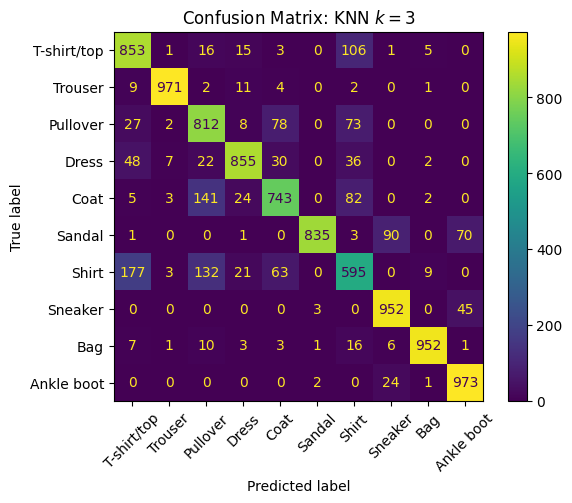


	KNN k=3

              precision    recall  f1-score   support

 T-shirt/top     0.7569    0.8530    0.8021      1000
     Trouser     0.9828    0.9710    0.9769      1000
    Pullover     0.7154    0.8120    0.7607      1000
       Dress     0.9115    0.8550    0.8824      1000
        Coat     0.8041    0.7430    0.7723      1000
      Sandal     0.9929    0.8350    0.9071      1000
       Shirt     0.6517    0.5950    0.6221      1000
     Sneaker     0.8872    0.9520    0.9185      1000
         Bag     0.9794    0.9520    0.9655      1000
  Ankle boot     0.8935    0.9730    0.9315      1000

    accuracy                         0.8541     10000
   macro avg     0.8575    0.8541    0.8539     10000
weighted avg     0.8575    0.8541    0.8539     10000



In [ ]:
show_ConfusionMatrix(k3_predicted_labels, "KNN $k=3$")
print('\n\tKNN k=3\n')
print(classification_report(test_labels, k3_predicted_labels, target_names=[LABEL_MAP(i) for i in range(10)], digits=4))

##### Results for KNN $k = 5$

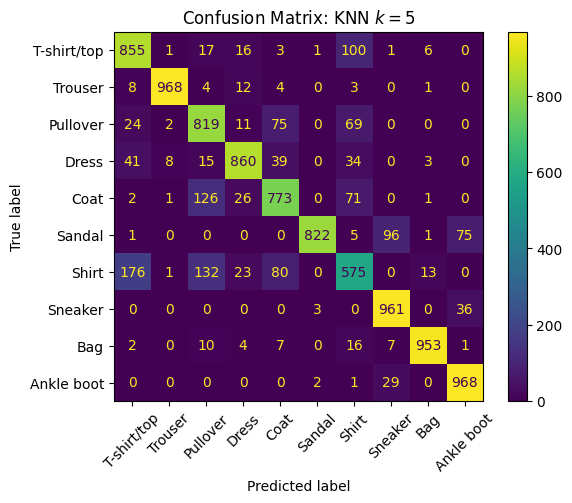


	KNN k=5

              precision    recall  f1-score   support

 T-shirt/top     0.7710    0.8550    0.8108      1000
     Trouser     0.9867    0.9680    0.9773      1000
    Pullover     0.7293    0.8190    0.7715      1000
       Dress     0.9034    0.8600    0.8811      1000
        Coat     0.7880    0.7730    0.7804      1000
      Sandal     0.9928    0.8220    0.8993      1000
       Shirt     0.6579    0.5750    0.6137      1000
     Sneaker     0.8784    0.9610    0.9179      1000
         Bag     0.9744    0.9530    0.9636      1000
  Ankle boot     0.8963    0.9680    0.9308      1000

    accuracy                         0.8554     10000
   macro avg     0.8578    0.8554    0.8546     10000
weighted avg     0.8578    0.8554    0.8546     10000



In [ ]:
show_ConfusionMatrix(k5_predicted_labels, "KNN $k=5$")
print('\n\tKNN k=5\n')
print(classification_report(test_labels, k5_predicted_labels, target_names=[LABEL_MAP(i) for i in range(10)], digits=4))

##### Results for KNN $k = 7$

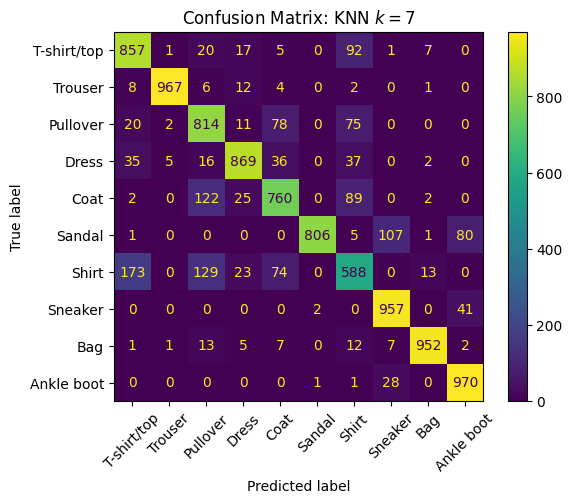


	KNN k=7

              precision    recall  f1-score   support

 T-shirt/top     0.7812    0.8570    0.8174      1000
     Trouser     0.9908    0.9670    0.9787      1000
    Pullover     0.7268    0.8140    0.7679      1000
       Dress     0.9033    0.8690    0.8858      1000
        Coat     0.7884    0.7600    0.7739      1000
      Sandal     0.9963    0.8060    0.8911      1000
       Shirt     0.6526    0.5880    0.6186      1000
     Sneaker     0.8700    0.9570    0.9114      1000
         Bag     0.9734    0.9520    0.9626      1000
  Ankle boot     0.8875    0.9700    0.9269      1000

    accuracy                         0.8540     10000
   macro avg     0.8570    0.8540    0.8534     10000
weighted avg     0.8570    0.8540    0.8534     10000



In [ ]:
show_ConfusionMatrix(k7_predicted_labels, "KNN $k=7$")
print('\n\tKNN k=7\n')
print(classification_report(test_labels, k7_predicted_labels, target_names=[LABEL_MAP(i) for i in range(10)], digits=4))

### Part 8

> Plot a graph (k vs macro F1 avg) with k in x-axis and macro F1 average in y-axis

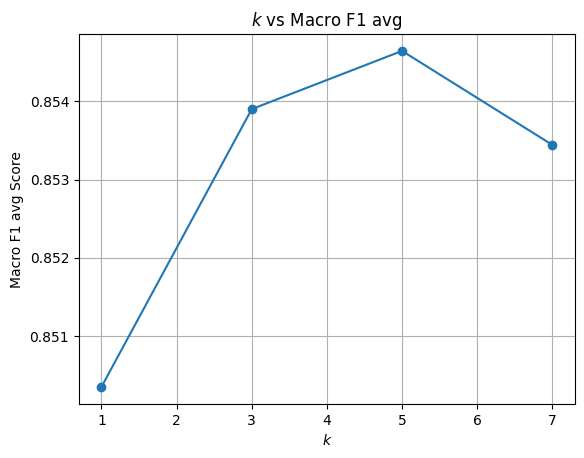

In [ ]:
k = [1, 3, 5, 7]
macro_f1_scores = [
    f1_score(test_labels, k1_predicted_labels, average='macro'),  # For k=1
    f1_score(test_labels, k3_predicted_labels, average='macro'),  # For k=3
    f1_score(test_labels, k5_predicted_labels, average='macro'),  # For k=5
    f1_score(test_labels, k7_predicted_labels, average='macro')]   # For k=7

plt.plot(k, macro_f1_scores, marker='o', linestyle='-')
plt.xlabel('$k$')
plt.ylabel('Macro F1 avg Score')
plt.title('$k$ vs Macro F1 avg')
plt.grid(True)
plt.show()

log_mfs = [np.exp(x) for x in macro_f1_scores]


From this we can conclude that $k=5$ is the best choice of k for KNN for this specific dataset.

## Assignment 1B

---

---

### Part 1-2

> Download, unzip and then load the Fashion MNIST dataset into your memory. You can directly load the Fashion dataset using the code provided here.
>
> You must read training and test images and labels in the numpy arrays.

In [ ]:
# Load training and test datasets
import numpy as np

train_images, train_labels, test_images, test_labels = download_and_load_dataset()

# the algorithms are designed with multiclass classification in mind and hence each image can be classified to more than one label,
# as a result, we can no longer interpret a label as just type (60000,), but rather (60000, k) where k is the number of classes
train_labels = np.eye(len(np.unique(train_labels)))[train_labels]
test_labels = np.eye(len(np.unique(test_labels)))[test_labels]

print(train_labels.shape, test_labels.shape)

Download complete.
(60000, 10) (10000, 10)


### Part 3

> Preprocess the train and test images.

In [ ]:
# norm_train_images = normalize(train_images) # Normalize pixel values to range [0, 1]
# stan_train_images = standardize(train_images)   # Standardize pixel values to have mean 0 and SD 1

# norm_test_images = normalize(test_images)
# stan_test_images = standardize(test_images)

train_images = normalize(train_images)
test_images = normalize(test_images)

# print("Training images")
for arr in (train_images, test_images):
  print("Max: ", np.max(arr))
  print("Min: ", np.min(arr))
  print("Mean is: ", np.mean(arr), "SD is: ", np.std(arr))
  print()


Max:  1.0
Min:  0.0
Mean is:  0.2860405969887955 SD is:  0.35302424451492237

Max:  1.0
Min:  0.0
Mean is:  0.2868492807122849 SD is:  0.35244415324744005



### Part 4

> Split the train images and the train labels into 80% train set and 20% validation set randomly.

> Train the linear classifier with softmax (as designed in class) and cross entropy loss with your train set with a batch size and a learning rate provided below.

We shall split the the training images first.

In [ ]:
# Augment the labels as a single column onto the train_images matrix

#train_set = np.vstack((train_images.T, train_labels)).T
train_set = np.hstack((train_images, train_labels))

# print(train_set.shape)
# print(train_set)
# print()

# shuffle the rows of train_set
np.random.shuffle(train_set)

# now extract out the last column vector again

train_images2 = train_set[:, :784]
train_labels2 = train_set[:, 784:]
# print(train_images2.shape)
# print(train_labels2.shape)
# print()

# Split out validation set (20% of the data)
split_index = int(train_images2.shape[0] * 0.2)

# split out training into validation
validation_images = train_images2[:split_index]
validation_labels = train_labels2[:split_index]

train_images = train_images2[split_index:]
train_labels = train_labels2[split_index:]

print("Validation images shape:", validation_images.shape)
print("Validation labels shape:", validation_labels.shape)
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)

del train_images2
del train_labels2

Validation images shape: (12000, 784)
Validation labels shape: (12000, 10)
Training images shape: (48000, 784)
Training labels shape: (48000, 10)


#### Linear Classifier

Softmax is a mathematical function commonly used in machine learning, especially in classification tasks, to convert raw model outputs (called logits) into probabilities. It ensures that the output values range between 0 and 1 and that the sum of these values is equal to 1, making them interpretable as probabilities.
$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
$$

Cross-entropy loss is a widely used loss function in classification tasks. It measures the difference between two probability distributions: the predicted probability distribution (output by a model) and the true probability distribution (the actual labels). The goal is to minimize this difference, making the model's predictions as close as possible to the true labels.

$$
L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$



In [ ]:
# cudapy can act as a in-place replacement for numpy that utilizes the gpu for faster processing,
# replace numpy with cupy only if you are on the GPU runtime

import cupy as np      # alias cudapy as np to ensure the linear classifier code runs via GPU
import numpy   # np is cupy now, use long name instead


def init_random_weights_and_bias(num_features: int, num_classes: int, seed: int = 1337) -> tuple:
    """Initializes the weights and bias involved in the Linear Classifier based on multinomial logistic regression.

    This works by initializing a random matrix of size <code>num_features * num_classes<code>
    """
    np.random.seed(seed)
    W = np.random.randn(num_features, num_classes) * 1e-5
    b = np.random.randn(num_classes) * 1e-3
    return W, b

def softmax(logits: np.array) -> np.array:
    """
    Applies the softmax transform onto an array.

    Each element of the array is exponentiated
    """

    # exp_logits = np.exp(logits)
    # return exp_logits / np.sum(exp_logits)
    # definition, so whats the problem? what if one of the elements is really large?
    # this causes an overflow

    exp_logits = np.exp(logits - np.max(logits)) # subtracting all elements by max causes the largest to be 0, and all others to be negative
                                             # to be negative, and e^(large neg) == 0, so no more problems with overflow
    return exp_logits / np.sum(exp_logits)

def derivative_softmax(logits: np.array, y: np.array) -> np.array:
    """ Compute the derivative of the softmax.
    :param logits: The logits.
    :type logits: np.array
    :param y: The labels.
    :type y: np.array
    """
    return softmax(logits) * (1 - softmax(logits))

def cross_entropy_loss(y: np.array, y_pred: np.array) -> float:
    """
    Calculate the cross-entropy loss.
    """
    # Clip the predictions to avoid log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    return -np.sum(y * np.log(y_pred)) / y.shape[0]

def forward(X: np.array, W: np.array, b: np.array) -> np.array:
    """
    Perform the forward pass.
    """
    #print(type(X), type(W))
    return softmax(np.dot(X, W) + b)

def backward(X: np.array, y: np.array, y_pred: np.array) -> tuple:
    """
    Perform the backward pass.
    """
    m = X.shape[0]
    dW = (1 / m) * np.dot(X.T, (y_pred - y))
    db = (1 / m) * np.sum((y_pred - y), axis=0)
    return dW, db

def update(W: np.array, b: np.array, dW: np.array, db: np.array, learning_rate: float) -> tuple:
    """
    Update the weights and bias.
    :param dW: The weights gradients.         // dW is a MATRIX OF derivatives!!!! thats the only way you could possibly decrement W by dW
    :param db: The bias gradients.
    """
    W -= learning_rate * dW
    b -= learning_rate * db
    return W, b


def validate(X: np.array, y: np.array, W: np.array, b: np.array, batch_size: int) -> tuple:
    """Validate the model."""

    # check if X and y are numpy arrays, and convert if necessary
    if not hasattr(X, 'get'):
        X = numpyarr_to_cupyarr(X)
    if not hasattr(y, 'get'):
        y = numpyarr_to_cupyarr(y)

    loss_val = 0
    predictions = []
    for i in range(0, X.shape[0], batch_size):
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        y_pred = forward(X_batch, W, b)
        loss_ = cross_entropy_loss(y_batch, y_pred)
        loss_val += loss_
        predictions.append(y_pred)
    loss_val /= X.shape[0]
    y_pred = np.concatenate(predictions, axis=0)

    return loss_val, y_pred



In [ ]:
def train(X: np.array, y: np.array, num_classes: int, num_epoch: int, lr: float, batch_size: int, seed: int = 42) -> tuple:
    """
    Train the model.
    """

    # convert X and y from numpy to cupy arrays
    X = numpyarr_to_cupyarr(X)
    y = numpyarr_to_cupyarr(y)

    num_samples, num_features = X.shape
    W, b = init_random_weights_and_bias(num_features, num_classes, seed)
    loss = {
        "train": [],
        "val": []
    }

    #print(type(W), type(b))

    for i in range(num_epoch):
        loss_epoch = 0

        loop = tqdm.tqdm(range(0, num_samples, batch_size), leave=False, ncols=100)
        for j in loop:
            X_batch = X[j:j+batch_size]
            y_batch = y[j:j+batch_size]

            # Forward pass
            #print(type(X_batch), type(W), type(b))
            y_pred = forward(X_batch, W, b)

            # Calculate loss
            loss_ = cross_entropy_loss(y_batch, y_pred)
            loss_epoch += loss_

            # Backward pass
            #print(X_batch.shape)
            #print(y_batch.shape)
            dW, db = backward(X_batch, y_batch, y_pred)

            # Update weights and bias
            W, b = update(W, b, dW, db, lr)

            loop.set_description(f"Epoch [{i+1}/{num_epoch}]")
            loop.set_postfix(loss=loss_)

        loss["train"].append(loss_epoch/num_samples)

        # Validate
        loss_val, y_pred = validate(X, y, W, b, batch_size)
        loss["val"].append(loss_val)

    # before you return convert cupy arrays to numpy arrays
    loss["val"] = cupyarr_to_numpyarr(np.array(loss["val"]).flatten())
    loss["train"] = cupyarr_to_numpyarr(np.array(loss["train"]).flatten())

    # we dont convert weights and bias, cause those are meant to be used by the classifier anyway
    # which uses gpu

    return W, b, loss


#import numpy as np    ## fix previous binding to cupy

#### GPU Compute

To optimize our training to run faster, we should utilize the GPU hardware as it can perform matrix multiplications much faster than CPU can, and is better suited for it as it has large data buses.

```python
# numpy - CPU
start = timer()
weight, bias, loss = train(train_images, train_labels, 10, 6, 0.1, 64)
end = timer()

print(end - start, "seconds")
```

```
57.12385930034321 seconds
```


```python
# cupy - GPU
start = timer()
weight, bias, loss = train(train_images, train_labels, 10, 6, 0.1, 64)
end = timer()

print(end - start, "seconds")
```

```
29.09435359300005 seconds
```

From this, we have shown that substantial improvement in performance and runtime can be made if we use cupy and GPU hardware to run the computations.





In [ ]:
!nvidia-smi

Sat Oct 19 21:22:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Workloads, 6

# convert the images to cupy arrays so they can be worked on by train()
# # conv_train_images = numpyarr_to_cupyarr(train_images)
# # conv_train_labels = numpyarr_to_cupyarr(train_labels)

# print(conv_train_images.shape, "type: ", type(conv_train_images), '\n')

# E1_results = train(train_images, train_labels, 10, 100, 0.001, 2048)
# print()
# E2_results = train(train_images, train_labels, 10, 100, 0.001, 1024)
# print()
# E3_results = train(train_images, train_labels, 10, 100, 0.001, 512)
# print()
# E4_results = train(train_images, train_labels, 10, 100, 0.0001, 2048)
# print()
# E5_results = train(train_images, train_labels, 10, 100, 0.0001, 1024)
# print()
# E6_results = train(train_images, train_labels, 10, 100, 0.0001, 512)
# print()

def write_results_to_file_and_download():
    f = open("1B_experiments.pkl", "wb")

    pickle.dump((E1_results, E2_results, E3_results, E4_results, E5_results, E6_results), f)

    f.close()
    files.download("1B_experiments.pkl")
    print("Saved results and downloaded them!")

def read_pickle_from_file_and_get_results():
    f = open("1B_experiments.pkl", "rb")
    results = pickle.load(f)

    return results

#write_results_to_file_and_download()
E1_results, E2_results, E3_results, E4_results, E5_results, E6_results = read_pickle_from_file_and_get_results()

In [ ]:
print(E1_results)
print(type(E1_results[0]))

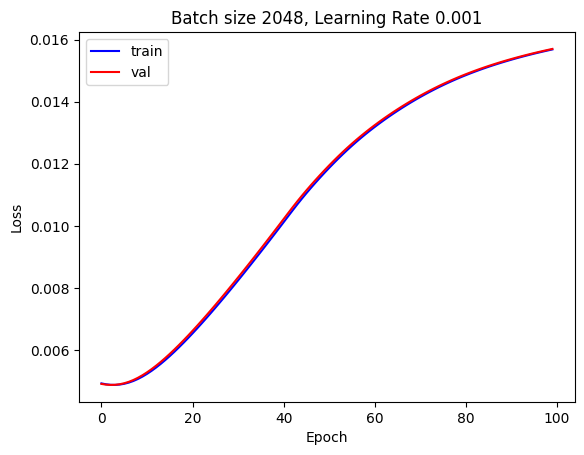

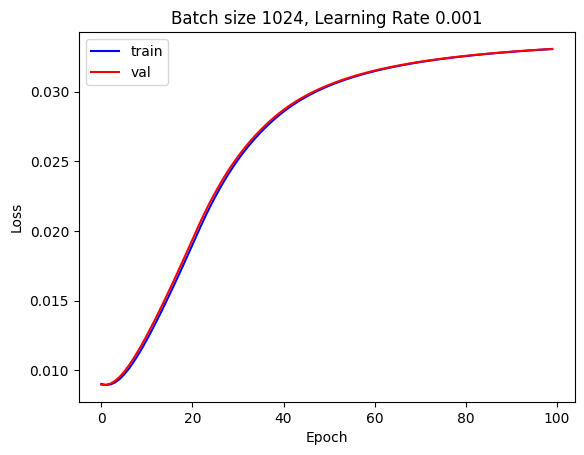

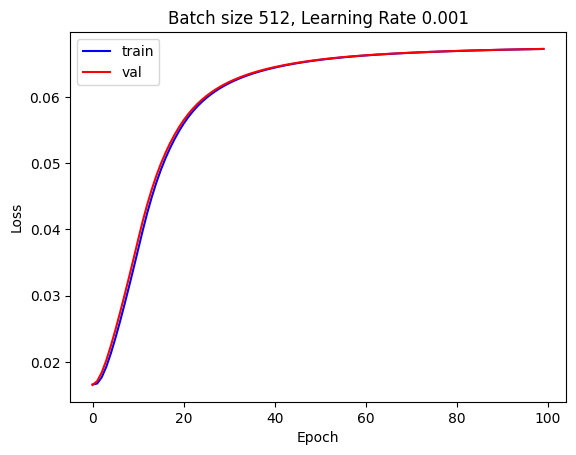

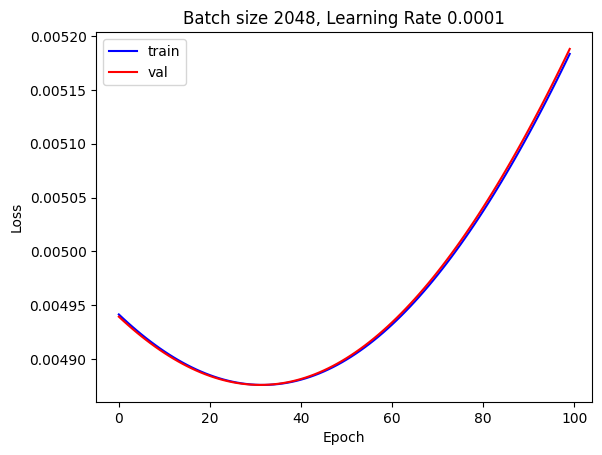

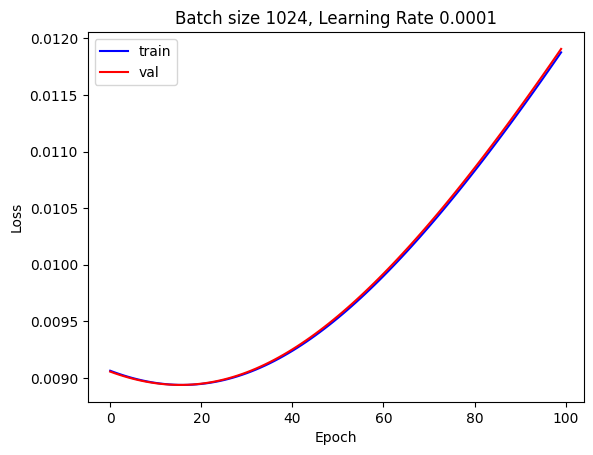

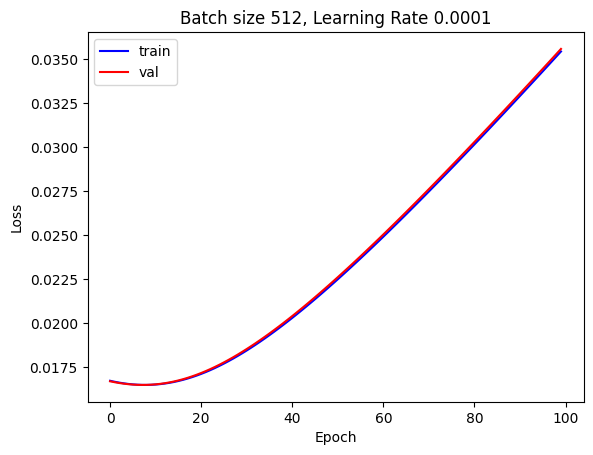

In [ ]:
def plot_learning_curve(loss, title: str):
    plt.plot(loss["train"], "b", label="train")
    plt.plot(loss["val"], "r", label="val")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_learning_curve(E1_results[-1], "Batch size 2048, Learning Rate 0.001")
plot_learning_curve(E2_results[-1], "Batch size 1024, Learning Rate 0.001")
plot_learning_curve(E3_results[-1], "Batch size 512, Learning Rate 0.001")
plot_learning_curve(E4_results[-1], "Batch size 2048, Learning Rate 0.0001")
plot_learning_curve(E5_results[-1], "Batch size 1024, Learning Rate 0.0001")
plot_learning_curve(E6_results[-1], "Batch size 512, Learning Rate 0.0001")

### Part 5

In [ ]:
def get_best_hyperparameters():
    best_f1 = 0
    best_model = None
    best_result = None
    best_hyperparameters = None
    results = [
        (E1_results, 0.001, 2048),
        (E2_results, 0.001, 1024),
        (E3_results, 0.001, 512),
        (E4_results, 0.0001, 2048),
        (E5_results, 0.0001, 1024),
        (E6_results, 0.0001, 512)
    ]

    for result, lr, batch_size in results:
        W, b, loss = result

        # Validate
        _, y_pred_val = validate(validation_images, validation_labels, W, b, batch_size)

        # Convert y_pred_val to NumPy for calculating F1 Score
        y_pred_val = cupyarr_to_numpyarr(y_pred_val)

        # Convert val_labels to NumPy
        # should be unnecessary but ok
        #val_labels = cupyarr_to_numpyarr(val_labels)


        # Use NumPy to find the true and predicted classes
        y_true = numpy.argmax(validation_labels, axis=1)  # Use NumPy for y_true
        y_pred = numpy.argmax(y_pred_val, axis=1)  # Use NumPy for y_pred

        # print(type(validation_labels))
        # print(type(y_true), type(y_pred))
        # Calculate F1 score
        f1 = f1_score(y_true, y_pred, average='macro')

        print(f1, lr, batch_size)

        if f1 > best_f1:
            best_f1 = f1
            best_model = (W, b)  # Keep them as CuPy arrays
            best_result = result
            best_hyperparameters = (lr, batch_size)

    return best_model, best_result, best_hyperparameters, best_f1


In [ ]:
# 1. Get the best hyperparameters
best_model, best_result, best_hyperparameters, best_f1 = get_best_hyperparameters()
best_lr, best_batch_size = best_hyperparameters

print("Best learning rate was {} and best batch size was {}".format(best_lr, best_batch_size))

# # 2. Train the model again using the best hyperparameters
# W_final, b_final, loss_final = train(train_images, train_labels, 10, 100, best_lr, best_batch_size)

# # 3. Validate on the test set
# test_loss, y_pred_test = validate(test_images, test_labels, W_final, b_final, best_batch_size)

0.2426850634306784 0.001 2048
0.28885759337288536 0.001 1024
0.35015760808807855 0.001 512
0.22476943652135084 0.0001 2048
0.2516938369077099 0.0001 1024
0.2872869500003847 0.0001 512
Best learning rate was 0.001 and best batch size was 512


Best F1 Score: 0.35015760808807855 with Learning Rate: 0.001 and Batch Size: 512


<Figure size 1000x700 with 0 Axes>

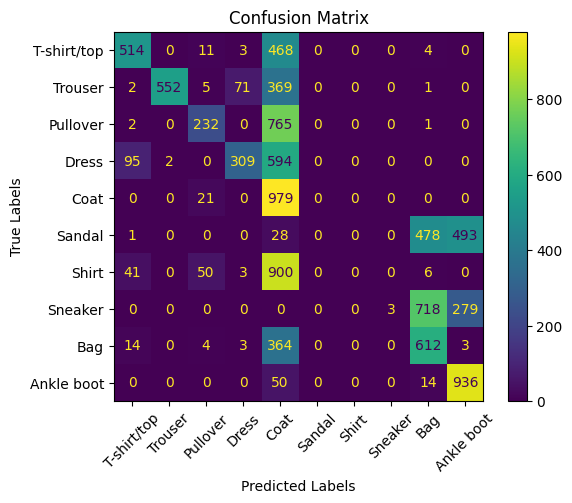

Linear Classifier

              precision    recall  f1-score   support

     Class 0       0.77      0.51      0.62      1000
     Class 1       1.00      0.55      0.71      1000
     Class 2       0.72      0.23      0.35      1000
     Class 3       0.79      0.31      0.44      1000
     Class 4       0.22      0.98      0.35      1000
     Class 5       0.00      0.00      0.00      1000
     Class 6       0.00      0.00      0.00      1000
     Class 7       1.00      0.00      0.01      1000
     Class 8       0.33      0.61      0.43      1000
     Class 9       0.55      0.94      0.69      1000

    accuracy                           0.41     10000
   macro avg       0.54      0.41      0.36     10000
weighted avg       0.54      0.41      0.36     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(f"Best F1 Score: {best_f1} with Learning Rate: {best_hyperparameters[0]} and Batch Size: {best_hyperparameters[1]}")

# Retrieve best learning rate and batch size
best_lr, best_batch_size = best_hyperparameters

# Train the model again using the best hyperparameters
W_final, b_final, loss_final = train(train_images, train_labels, 10, 100, best_lr, best_batch_size)


#  Convert predictions and true labels to NumPy arrays
y_true_test = numpy.argmax(test_labels, axis=1)
y_pred_test = cupyarr_to_numpyarr(y_pred_test)
y_pred_test = numpy.argmax(y_pred_test, axis=1)  # Predictions from the model

#print(type(y_true_test), type(y_pred_test))
#  Generate confusion matrix
conf_matrix = confusion_matrix(y_true_test, y_pred_test)

#  Display confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[LABEL_MAP(i) for i in range(10)])
disp = disp.plot(xticks_rotation=45)
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Linear Classifier\n")
print(classification_report(y_true_test, y_pred_test, target_names=[f'Class {i}' for i in range(10)]))




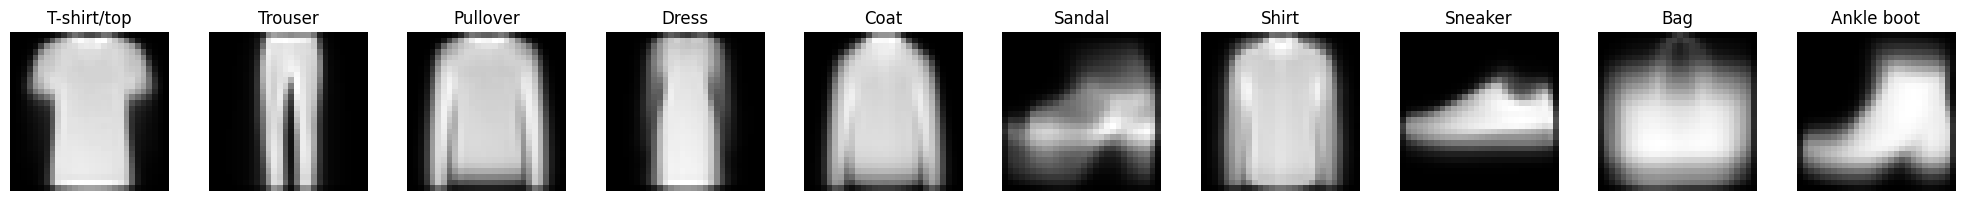

In [ ]:
def plot_learned_weights(W: np.array, num_classes: int, img_shape: tuple):
    """
    Plot the learned weights for each class.

    :param W: Weights matrix (num_features x num_classes)
    :param num_classes: Number of classes
    :param img_shape: Shape of the images (height, width)
    """
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 2, 2))
    W = cupyarr_to_numpyarr(W)

    for i in range(num_classes):
        ax = axes[i]
        weight_image = W[:, i].reshape(img_shape)  # Reshape the weight vector for the class
        ax.imshow(weight_image, cmap='gray')
        ax.set_title(LABEL_MAP(i))
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with the final weights
plot_learned_weights(W_final, 10, (28, 28))
